In [14]:
import kagglehub

path = kagglehub.dataset_download("PriYaa652/microscopic-image-of-different-processed-rice")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/microscopic-image-of-different-processed-rice


Aush: Attempting RGBe to RGB conversion.
BR-28: Attempting RGBe to RGB conversion.
BR-29: Attempting RGBe to RGB conversion.
Beroi: Attempting RGBe to RGB conversion.
Chinigura: Attempting RGBe to RGB conversion.
Ghee Bhog: Attempting RGBe to RGB conversion.
Katari Najir: Attempting RGBe to RGB conversion.
Katari Siddho: Attempting RGBe to RGB conversion.
Miniket: Attempting RGBe to RGB conversion.
Swarna: Attempting RGBe to RGB conversion.


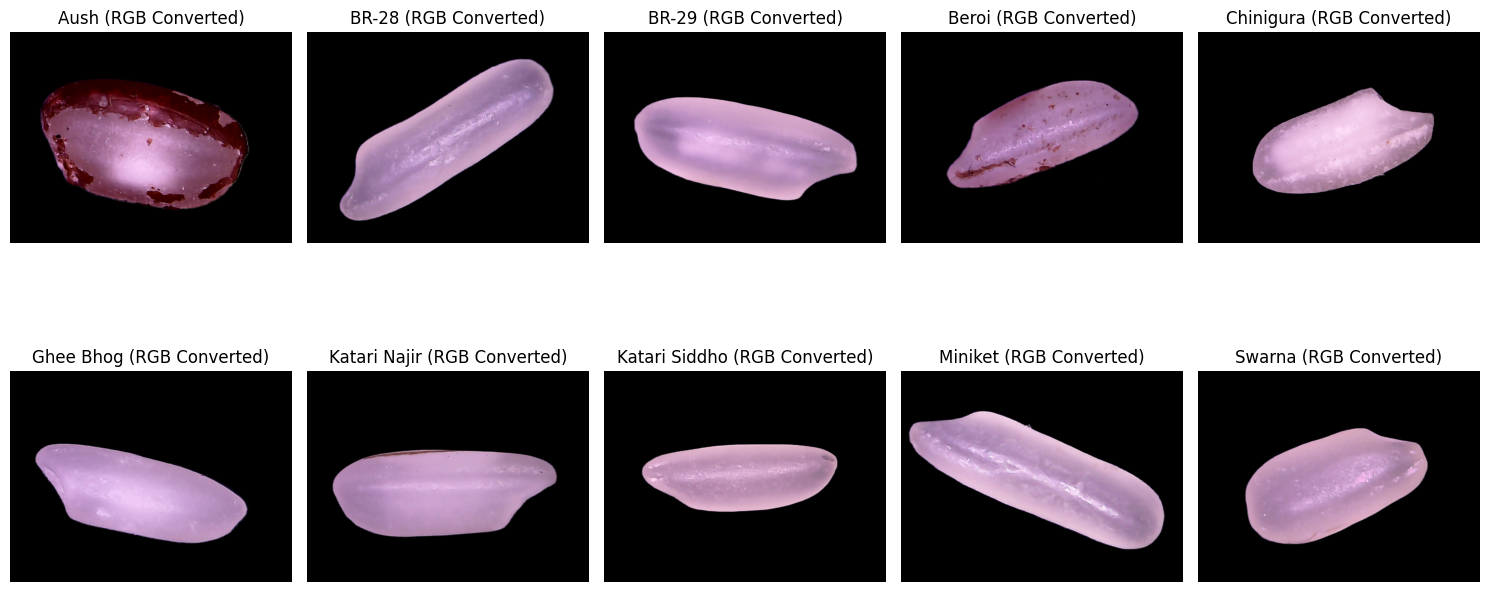

In [15]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# ---------- Function: RGBe → RGB (smooth, non-binary) ----------
def rgbe_to_rgb(img):
    """Converts a 4-channel RGBe image to smooth RGB (0-255)."""
    if img is None or img.ndim != 3 or img.shape[2] != 4:
        print("Warning: Input is not a valid 4-channel image for RGBe conversion.")
        return None

    r, g, b, e = cv2.split(img.astype(np.float32))
    scale = np.exp2(e - 128.0)
    rgb = np.stack([(r / 255) * scale, (g / 255) * scale, (b / 255) * scale], axis=-1)

    # Normalize to 0-255 without binary mapping
    rgb_min, rgb_max = rgb.min(), rgb.max()
    if rgb_max - rgb_min > 0:
        rgb = (rgb - rgb_min) / (rgb_max - rgb_min)
    else:
        rgb = np.zeros_like(rgb)
    rgb = (rgb * 255).astype(np.uint8)

    return rgb

# ---------- Folder paths ----------
dataset_dir = "/kaggle/input/microscopic-image-of-different-processed-rice/PRBD Microscopic Image of Different Processed Rice/Original_Images"

if not os.path.exists(dataset_dir):
    print(f"Error: Dataset directory not found at {dataset_dir}. Please ensure the dataset is downloaded and extracted correctly.")
else:
    classes = sorted(os.listdir(dataset_dir))

    plt.figure(figsize=(15, 8))

    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_dir, cls)

        if not os.path.isdir(class_path):
            print(f"Skipping {cls}: Not a directory.")
            continue

        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not image_files:
            print(f"{cls}: No image files found, skipping.")
            continue

        img_path = os.path.join(class_path, image_files[0])
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

        img_to_display = None
        title_text = cls

        if img is not None and isinstance(img, np.ndarray):
            if img.ndim == 3:  # Color images
                if img.shape[2] == 4:  # RGBe
                    print(f"{cls}: Attempting RGBe to RGB conversion.")
                    img_rgb = rgbe_to_rgb(img)
                    if img_rgb is not None:
                        img_to_display = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
                        title_text += " (RGB Converted)"
                    else:
                        print(f"{cls}: Failed RGBe to RGB conversion.")
                elif img.shape[2] == 3:  # Normal RGB
                    print(f"{cls}: Normal RGB image, using directly.")
                    img_to_display = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)
                    title_text += " (Original RGB)"
                else:
                    print(f"{cls}: Unsupported number of channels ({img.shape[2]}), skipping.")
            elif img.ndim == 2:  # Grayscale
                print(f"{cls}: Grayscale image, skipping for visualization.")
            else:
                print(f"{cls}: Unsupported number of dimensions ({img.ndim}), skipping.")
        else:
            print(f"{cls}: Could not load image at {img_path} or it is not a valid numpy array, skipping.")

        # Plotting
        plt.subplot(2, (len(classes) + 1) // 2, i + 1)
        if img_to_display is not None:
            plt.imshow(img_to_display)
            plt.title(title_text)
        else:
            plt.text(0.5, 0.5, "Image Skipped", horizontalalignment='center', verticalalignment='center')
            plt.title(title_text + " (Skipped)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [16]:
import os
import shutil
import numpy as np
import time

dataset_dir = "/kaggle/input/microscopic-image-of-different-processed-rice/PRBD Microscopic Image of Different Processed Rice/Original_Images"
split_base_dir = '/kaggle/working/split_data'

#  Force remove old directory (wait to ensure it's deleted)
if os.path.exists(split_base_dir):
    shutil.rmtree(split_base_dir)
    time.sleep(1)  # wait a bit so system finishes deleting

# Recreate clean structure
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
splits = ['train', 'val', 'test']

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(split_base_dir, split, cls), exist_ok=True)

# Perform split (30:70, 10% val of 30%)
for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    images = sorted(os.listdir(class_dir))
    np.random.shuffle(images)
    total = len(images)

    # Calculate splits
    train_val_count = int(total * 0.3)
    val_count = int(train_val_count * 0.1)
    train_count = train_val_count - val_count
    test_count = total - train_val_count

    print(f"\nClass: {cls}")
    print(f"Total: {total}, Train: {train_count}, Val: {val_count}, Test: {test_count}")

    train_val_images = images[:train_val_count]
    test_images = images[train_val_count:]
    val_images = train_val_images[:val_count]
    train_images = train_val_images[val_count:]

    split_images = {'train': train_images, 'val': val_images, 'test': test_images}

    for split in splits:
        for img_name in split_images[split]:
            src = os.path.join(class_dir, img_name)
            dst = os.path.join(split_base_dir, split, cls, img_name)
            shutil.copy(src, dst)


print("\n=== Final Split Summary ===\n")
for split in splits:
    print(f"--- {split.upper()} ---")
    for cls in classes:
        split_cls_dir = os.path.join(split_base_dir, split, cls)
        count = len(os.listdir(split_cls_dir))
        print(f"{cls}: {count}")
    print()



Class: Swarna
Total: 200, Train: 54, Val: 6, Test: 140

Class: Katari Siddho
Total: 200, Train: 54, Val: 6, Test: 140

Class: Beroi
Total: 200, Train: 54, Val: 6, Test: 140

Class: BR-29
Total: 200, Train: 54, Val: 6, Test: 140

Class: Katari Najir
Total: 200, Train: 54, Val: 6, Test: 140

Class: Miniket
Total: 200, Train: 54, Val: 6, Test: 140

Class: Chinigura
Total: 200, Train: 54, Val: 6, Test: 140

Class: Ghee Bhog
Total: 200, Train: 54, Val: 6, Test: 140

Class: BR-28
Total: 200, Train: 54, Val: 6, Test: 140

Class: Aush
Total: 200, Train: 54, Val: 6, Test: 140

=== Final Split Summary ===

--- TRAIN ---
Swarna: 54
Katari Siddho: 54
Beroi: 54
BR-29: 54
Katari Najir: 54
Miniket: 54
Chinigura: 54
Ghee Bhog: 54
BR-28: 54
Aush: 54

--- VAL ---
Swarna: 6
Katari Siddho: 6
Beroi: 6
BR-29: 6
Katari Najir: 6
Miniket: 6
Chinigura: 6
Ghee Bhog: 6
BR-28: 6
Aush: 6

--- TEST ---
Swarna: 140
Katari Siddho: 140
Beroi: 140
BR-29: 140
Katari Najir: 140
Miniket: 140
Chinigura: 140
Ghee Bhog: 140


Found 934 images belonging to 10 classes.
Found 119 images belonging to 10 classes.
Found 1812 images belonging to 10 classes.
Epoch 1/50
30/30 - 74s - 2s/step - accuracy: 0.4668 - loss: 1.5308 - val_accuracy: 0.7479 - val_loss: 0.8366 - learning_rate: 0.0010
Epoch 2/50
30/30 - 8s - 264ms/step - accuracy: 0.7216 - loss: 0.8077 - val_accuracy: 0.7983 - val_loss: 0.6565 - learning_rate: 0.0010
Epoch 3/50
30/30 - 8s - 257ms/step - accuracy: 0.7827 - loss: 0.6710 - val_accuracy: 0.8151 - val_loss: 0.5865 - learning_rate: 0.0010
Epoch 4/50
30/30 - 8s - 257ms/step - accuracy: 0.8126 - loss: 0.5686 - val_accuracy: 0.7731 - val_loss: 0.6775 - learning_rate: 0.0010
Epoch 5/50
30/30 - 8s - 255ms/step - accuracy: 0.7955 - loss: 0.6102 - val_accuracy: 0.8403 - val_loss: 0.5702 - learning_rate: 0.0010
Epoch 6/50
30/30 - 8s - 258ms/step - accuracy: 0.8587 - loss: 0.4763 - val_accuracy: 0.8319 - val_loss: 0.5520 - learning_rate: 0.0010
Epoch 7/50
30/30 - 8s - 254ms/step - accuracy: 0.8555 - loss: 0.4

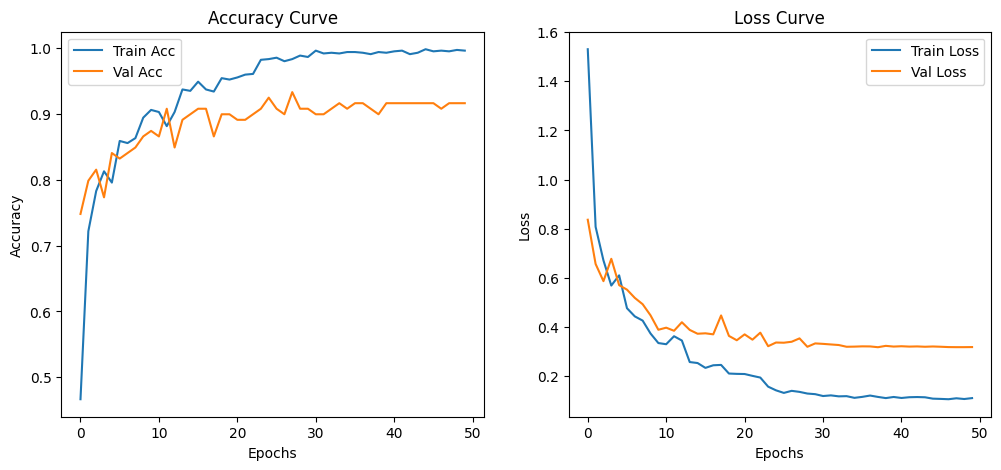


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     1.0000    0.9779    0.9888       181
Katari Siddho     0.9162    0.8407    0.8768       182
        Beroi     0.9050    0.8852    0.8950       183
        BR-29     0.9838    1.0000    0.9918       182
 Katari Najir     0.9886    0.9774    0.9830       177
      Miniket     0.8901    0.9101    0.9000       178
    Chinigura     0.9050    0.9000    0.9025       180
    Ghee Bhog     0.8802    0.9135    0.8966       185
        BR-28     0.9560    0.9613    0.9587       181
         Aush     0.9021    0.9563    0.9284       183

     accuracy                         0.9321      1812
    macro avg     0.9327    0.9322    0.9322      1812
 weighted avg     0.9325    0.9321    0.9320      1812



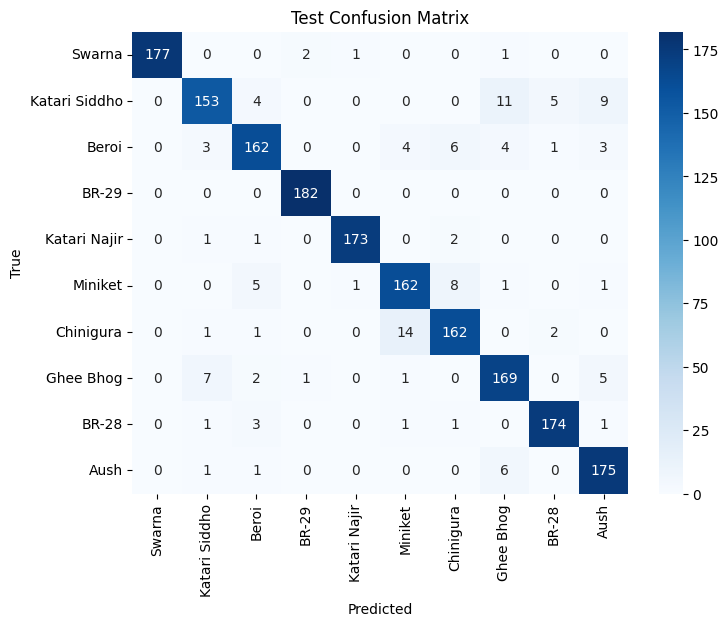

Swarna Accuracy: 0.9779
Katari Siddho Accuracy: 0.8407
Beroi Accuracy: 0.8852
BR-29 Accuracy: 1.0000
Katari Najir Accuracy: 0.9774
Miniket Accuracy: 0.9101
Chinigura Accuracy: 0.9000
Ghee Bhog Accuracy: 0.9135
BR-28 Accuracy: 0.9613
Aush Accuracy: 0.9563
Test AUC: 0.9960
Test PR AUC: 0.9746

Training Time: 452.50 seconds


In [41]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# Paths and parameters

split_base_dir = '/kaggle/working/split_data'
img_size = (224, 224)
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]


# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: NASNetMobile
# -----------------------------
def build_nasnetmobile_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = NASNetMobile(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

nasnet_model = build_nasnetmobile_model(num_classes=num_classes)
nasnet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callback (only LR scheduler, no early stop)
# -----------------------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training (50 epochs, no early stop)
# -----------------------------
start_time = time.time()
history = nasnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[reduce_lr],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, nasnet_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, nasnet_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, nasnet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# AUC & PR
print(f"Test AUC: {roc_auc_score(test_true_prob, test_pred_prob, average='macro', multi_class='ovr'):.4f}")
print(f"Test PR AUC: {average_precision_score(test_true_prob, test_pred_prob, average='macro'):.4f}")

print(f"\nTraining Time: {training_time:.2f} seconds")

Macro Precision: 0.8508
Macro Recall: 0.8486
Macro F1-score: 0.8485
Swarna: Precision=0.9852, Recall=0.9500, F1=0.9673
Katari Siddho: Precision=0.7820, Recall=0.7429, F1=0.7619
Beroi: Precision=0.7895, Recall=0.7500, F1=0.7692
BR-29: Precision=0.9640, Recall=0.9571, F1=0.9606
Katari Najir: Precision=0.9510, Recall=0.9714, F1=0.9611
Miniket: Precision=0.7202, Recall=0.8643, F1=0.7857
Chinigura: Precision=0.7742, Recall=0.6857, F1=0.7273
Ghee Bhog: Precision=0.7586, Recall=0.7857, F1=0.7719
BR-28: Precision=0.9556, Recall=0.9214, F1=0.9382
Aush: Precision=0.8276, Recall=0.8571, F1=0.8421


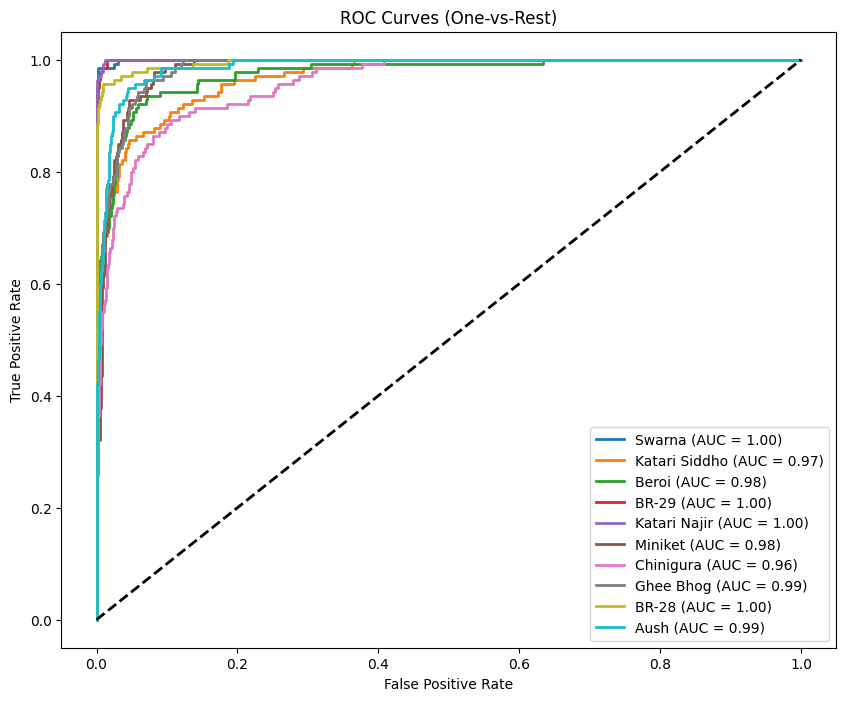

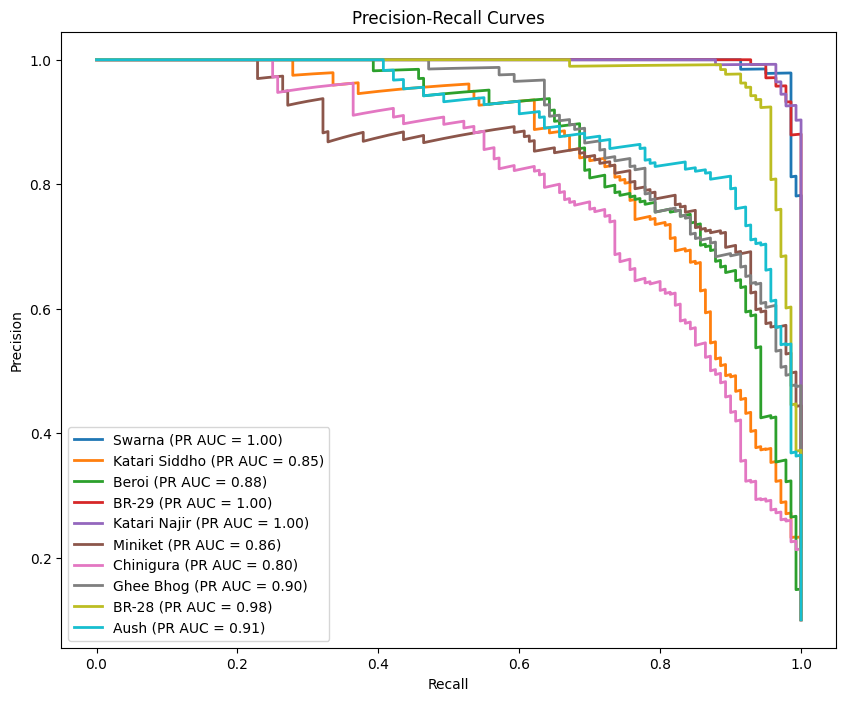

Total inference time: 37.34 sec
Inference time per sample: 0.026673 sec

Most confused class pairs:
Swarna is most often confused with BR-29 (3 samples)
Katari Siddho is most often confused with Ghee Bhog (19 samples)
Beroi is most often confused with Chinigura (11 samples)
BR-29 is most often confused with Swarna (2 samples)
Katari Najir is most often confused with Chinigura (2 samples)
Miniket is most often confused with Chinigura (12 samples)
Chinigura is most often confused with Miniket (35 samples)
Ghee Bhog is most often confused with Katari Siddho (11 samples)
BR-28 is most often confused with Beroi (5 samples)
Aush is most often confused with Ghee Bhog (9 samples)


In [6]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, average_precision_score, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.applications import NASNetMobile

# -----------------------------
# Assume you already have:
# test_true: true labels (as integers)
# test_pred_prob: predicted probabilities from model.predict
# test_pred: predicted class labels (argmax of test_pred_prob)
# classes: list of class names
# num_classes: total number of classes
# -----------------------------

# -----------------------------
# Macro metrics
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro', zero_division=0)
macro_recall = recall_score(test_true, test_pred, average='macro', zero_division=0)
macro_f1 = f1_score(test_true, test_pred, average='macro', zero_division=0)

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# -----------------------------
# Per-class metrics
# -----------------------------
per_class_precision = precision_score(test_true, test_pred, average=None, zero_division=0)
per_class_recall = recall_score(test_true, test_pred, average=None, zero_division=0)
per_class_f1 = f1_score(test_true, test_pred, average=None, zero_division=0)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# Precision-Recall curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Inference time per sample
# -----------------------------
nasnet_model = NASNetMobile(weights='imagenet', include_top=False)  # dummy, replace with your trained model
start_infer = time.time()
_ = nasnet_model.predict(test_gen, verbose=0)  # test_gen = your test generator
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")

# -----------------------------
# Most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [7]:
start_test = time.time()
_ = nasnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

Inference Time per sample: 0.007734 seconds


In [8]:
# Calculate and print the number of parameters
total_params = nasnet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 4,269,716
Trainable Parameters: 4,232,978
Non-Trainable Parameters: 36,738


Found 540 images belonging to 10 classes.
Found 60 images belonging to 10 classes.
Found 1400 images belonging to 10 classes.
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
17/17 - 36s - 2s/step - accuracy: 0.1333 - loss: 2.5489 - val_accuracy: 0.2333 - val_loss: 2.1247 - learning_rate: 0.0010
Epoch 2/50
17/17 - 10s - 597ms/step - accuracy: 0.1944 - loss: 2.1913 - val_accuracy: 0.4000 - val_loss: 1.9525 - learning_rate: 0.0010
Epoch 3/50
17/17 - 10s - 599ms/step - accuracy: 0.2574 - loss: 2.0304 - val_accuracy: 0.4000 - val_loss: 1.8425 - learning_rate: 0.0010
Epoch 4/50
17/17 - 10s - 598ms/step - accuracy: 0.2833 - loss: 1.9028 - val_accuracy: 0.3333 - val_loss: 1.7448 - learning_rate: 0.0010
Epoch 5/50
17/17 - 10s - 596ms/step - accuracy: 0.3222 - loss: 1.8044 - val_accuracy: 0.3667 - val_loss: 1.7184 - learning_rate: 0.0010
Epoch 6/50
17/17 - 10s - 588ms/step - accuracy: 0.3778 - loss: 1.7815 - val_accuracy: 0.4500 - val_loss: 1.6527 - learning_rate: 0.0010
Epoch 7/50
17/17 - 10s - 597ms/step - accuracy: 0.3704 - loss: 1.7117 - val_accuracy: 0.4000 - val_loss: 1.6245 - learning_rate: 0.0010
Epoch 8/50
17/17 - 10s - 596ms/step - accuracy: 0.3

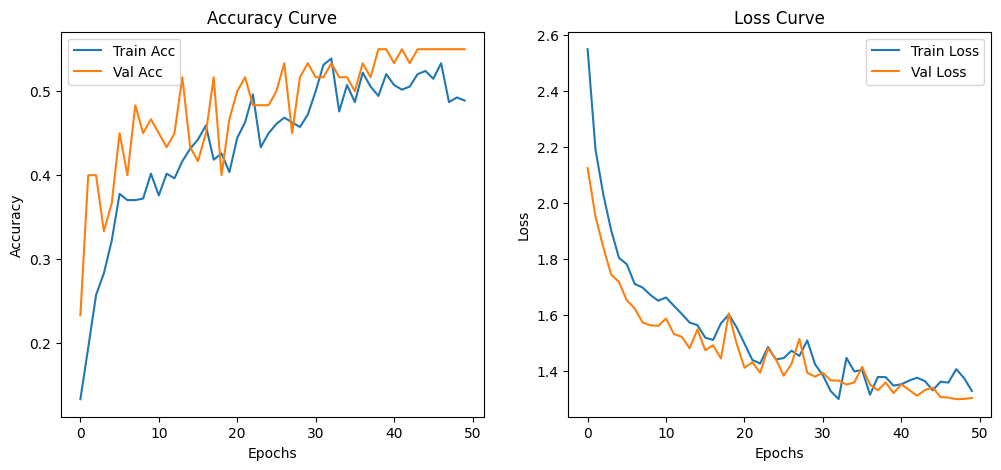


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.7333    0.8643    0.7934       140
Katari Siddho     0.3656    0.2429    0.2918       140
        Beroi     0.5435    0.3571    0.4310       140
        BR-29     0.9048    0.2714    0.4176       140
 Katari Najir     0.7635    0.8071    0.7847       140
      Miniket     0.4689    0.8071    0.5932       140
    Chinigura     0.6226    0.2357    0.3420       140
    Ghee Bhog     0.5321    0.5929    0.5608       140
        BR-28     0.6283    0.8571    0.7251       140
         Aush     0.5616    0.8786    0.6852       140

     accuracy                         0.5914      1400
    macro avg     0.6124    0.5914    0.5625      1400
 weighted avg     0.6124    0.5914    0.5625      1400



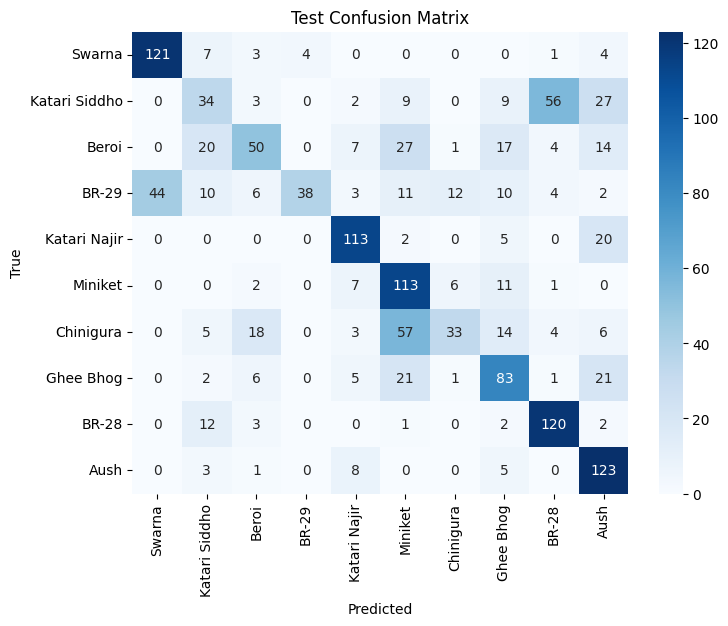

Swarna Accuracy: 0.8643
Katari Siddho Accuracy: 0.2429
Beroi Accuracy: 0.3571
BR-29 Accuracy: 0.2714
Katari Najir Accuracy: 0.8071
Miniket Accuracy: 0.8071
Chinigura Accuracy: 0.2357
Ghee Bhog Accuracy: 0.5929
BR-28 Accuracy: 0.8571
Aush Accuracy: 0.8786
Test AUC: 0.9302
Test PR AUC: 0.6599

Training Time: 527.83 seconds


In [11]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'  # 30% train, 70% val+test
dataset_dir = "/kaggle/input/microscopic-image-of-different-processed-rice/PRBD Microscopic Image of Different Processed Rice/Original_Images"
img_size = (224, 224)
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators with strong augmentation
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Compute class weights
# -----------------------------
train_labels = train_gen.classes
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

# -----------------------------
# Build ConvNeXtTiny model
# -----------------------------
def build_convnext_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = ConvNeXtTiny(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone initially
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

convnext_model = build_convnext_model(num_classes=num_classes)
convnext_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = convnext_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,  
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, convnext_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, convnext_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, convnext_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

print(f"Test AUC: {roc_auc_score(test_true_prob, test_pred_prob, average='macro', multi_class='ovr'):.4f}")
print(f"Test PR AUC: {average_precision_score(test_true_prob, test_pred_prob, average='macro'):.4f}")

print(f"\nTraining Time: {training_time:.2f} seconds")


Macro Precision: 0.6124
Macro Recall: 0.5914
Macro F1-score: 0.5625
Swarna: Precision=0.7333, Recall=0.8643, F1=0.7934
Katari Siddho: Precision=0.3656, Recall=0.2429, F1=0.2918
Beroi: Precision=0.5435, Recall=0.3571, F1=0.4310
BR-29: Precision=0.9048, Recall=0.2714, F1=0.4176
Katari Najir: Precision=0.7635, Recall=0.8071, F1=0.7847
Miniket: Precision=0.4689, Recall=0.8071, F1=0.5932
Chinigura: Precision=0.6226, Recall=0.2357, F1=0.3420
Ghee Bhog: Precision=0.5321, Recall=0.5929, F1=0.5608
BR-28: Precision=0.6283, Recall=0.8571, F1=0.7251
Aush: Precision=0.5616, Recall=0.8786, F1=0.6852


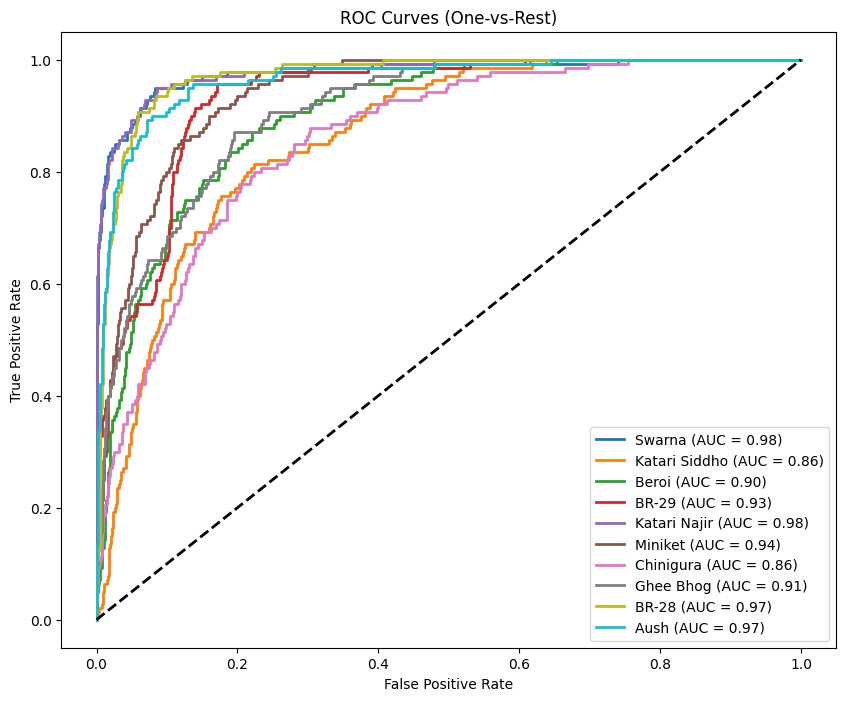

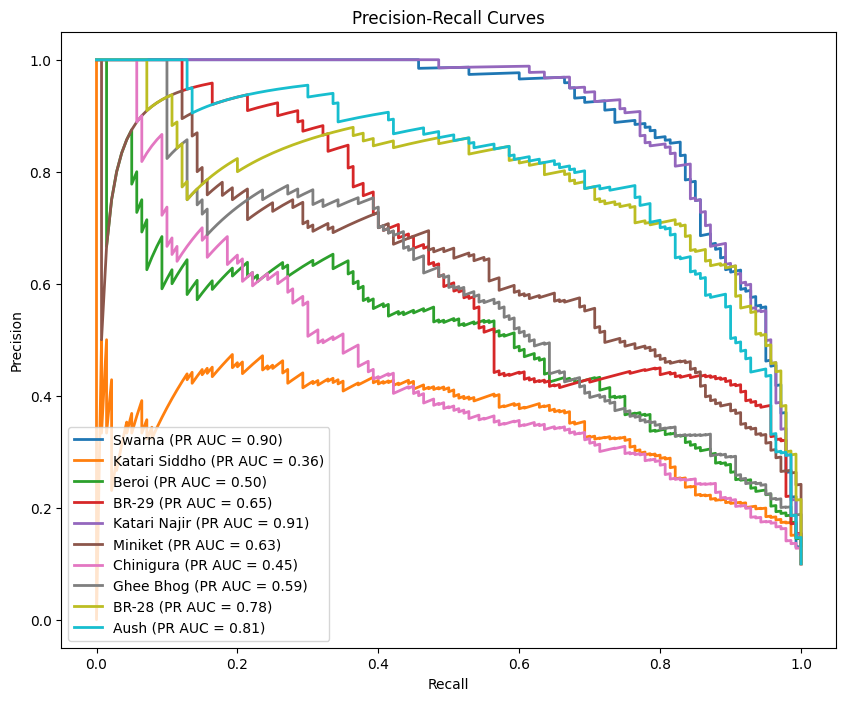


Most confused class pairs:
Swarna is most often confused with Katari Siddho (7 samples)
Katari Siddho is most often confused with BR-28 (56 samples)
Beroi is most often confused with Miniket (27 samples)
BR-29 is most often confused with Swarna (44 samples)
Katari Najir is most often confused with Aush (20 samples)
Miniket is most often confused with Ghee Bhog (11 samples)
Chinigura is most often confused with Miniket (57 samples)
Ghee Bhog is most often confused with Miniket (21 samples)
BR-28 is most often confused with Katari Siddho (12 samples)
Aush is most often confused with Katari Najir (8 samples)


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, average_precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import time
import matplotlib.pyplot as plt

# -----------------------------
# Precision, Recall, F1-score
# -----------------------------
macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# Per-class scores
per_class_precision = precision_score(test_true, test_pred, average=None)
per_class_recall = recall_score(test_true, test_pred, average=None)
per_class_f1 = f1_score(test_true, test_pred, average=None)

for i, cls in enumerate(classes):
    print(f"{cls}: Precision={per_class_precision[i]:.4f}, Recall={per_class_recall[i]:.4f}, F1={per_class_f1[i]:.4f}")

# -----------------------------
# ROC–AUC curves (One-vs-Rest)
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# PR curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# Failure modes: most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0  # ignore correct predictions
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [16]:
start_test = time.time()
_ = convnext_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")

Inference Time per sample: 0.007469 seconds


In [17]:
# Calculate and print the number of parameters
total_params = convnext_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in nasnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")

Total Parameters: 28,218,986
Trainable Parameters: 4,232,978
Non-Trainable Parameters: 36,738


Found 934 images belonging to 10 classes.
Found 119 images belonging to 10 classes.
Found 1812 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
30/30 - 58s - 2s/step - accuracy: 0.4572 - loss: 1.6461 - val_accuracy: 0.7227 - val_loss: 0.8947 - learning_rate: 0.0010
Epoch 2/30
30/30 - 27s - 888ms/step - accuracy: 0.7099 - loss: 0.9062 - val_accuracy: 0.7395 - val_loss: 0.7339 - learning_rate: 0.0010
Epoch 3/30
30/30 - 26s - 876ms/step - accuracy: 0.7580 - loss: 0.7380 - val_accuracy: 0.7647 - val_loss: 0.6113 - learning_rate: 0.0010
Epoch 4/30
30/30 - 26s - 869ms/step - accuracy: 0.7719 - loss: 0.7080 - val_accuracy: 0.7311 - val_loss: 0.7083 - learning_rate: 0.0010
Epoch 5/30
30/30 - 26s - 876ms/step - accuracy: 0.7869 - loss: 0.6575 - val_accuracy: 0.8403 - val_loss: 0.4953 - learning_rate: 0.0010
Epoch 6/30
30/30 - 26s - 883ms/step - accuracy: 0.7901 - loss: 0.6414 - val_accuracy: 0.8319 - val_loss: 0.5766 - learning_rate: 0.0010
Epoch 7/30
30/30 - 26s - 863ms/step - accuracy: 0.7923 - loss: 0.6005 - val_accuracy: 0.8235 - val_loss: 0.4787 - learning_rate: 0.0010
Epoch 8/30
30/30 - 26s - 871ms/step - accuracy: 0.8

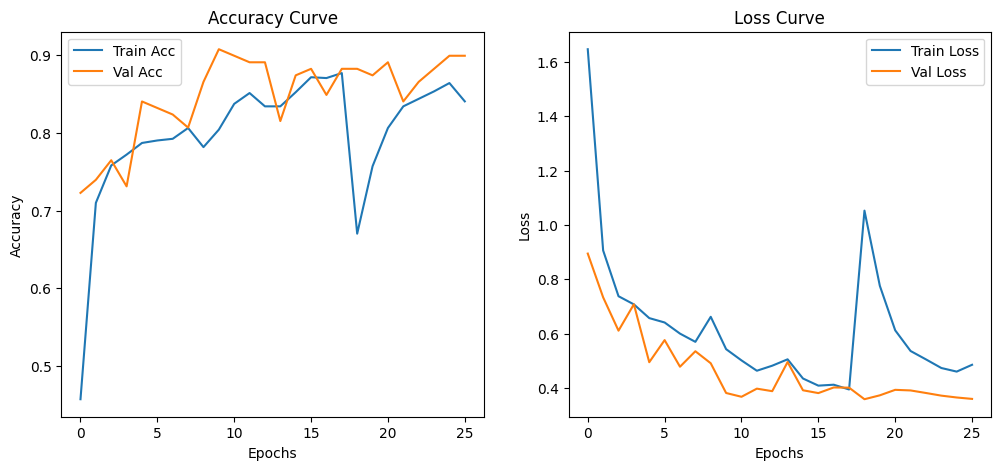


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.9777    0.9669    0.9722       181
Katari Siddho     0.8012    0.7308    0.7644       182
        Beroi     0.8981    0.7705    0.8294       183
        BR-29     0.9727    0.9780    0.9753       182
 Katari Najir     0.9943    0.9774    0.9858       177
      Miniket     0.7184    0.9888    0.8322       178
    Chinigura     0.9035    0.5722    0.7007       180
    Ghee Bhog     0.7076    0.9027    0.7933       185
        BR-28     0.9819    0.9006    0.9395       181
         Aush     0.8229    0.8634    0.8427       183

     accuracy                         0.8648      1812
    macro avg     0.8778    0.8651    0.8635      1812
 weighted avg     0.8774    0.8648    0.8632      1812



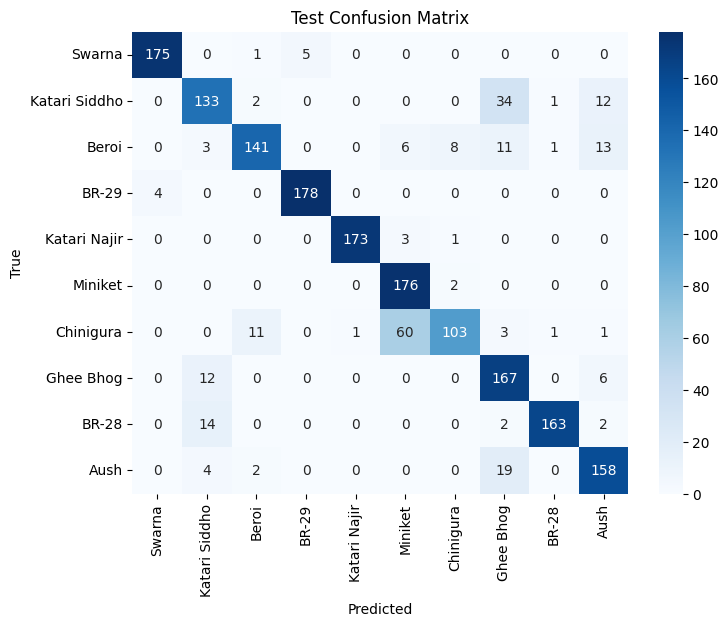

Swarna Accuracy: 0.9669
Katari Siddho Accuracy: 0.7308
Beroi Accuracy: 0.7705
BR-29 Accuracy: 0.9780
Katari Najir Accuracy: 0.9774
Miniket Accuracy: 0.9888
Chinigura Accuracy: 0.5722
Ghee Bhog Accuracy: 0.9027
BR-28 Accuracy: 0.9006
Aush Accuracy: 0.8634
Macro Precision: 0.8778, Macro Recall: 0.8651, Macro F1-score: 0.8635


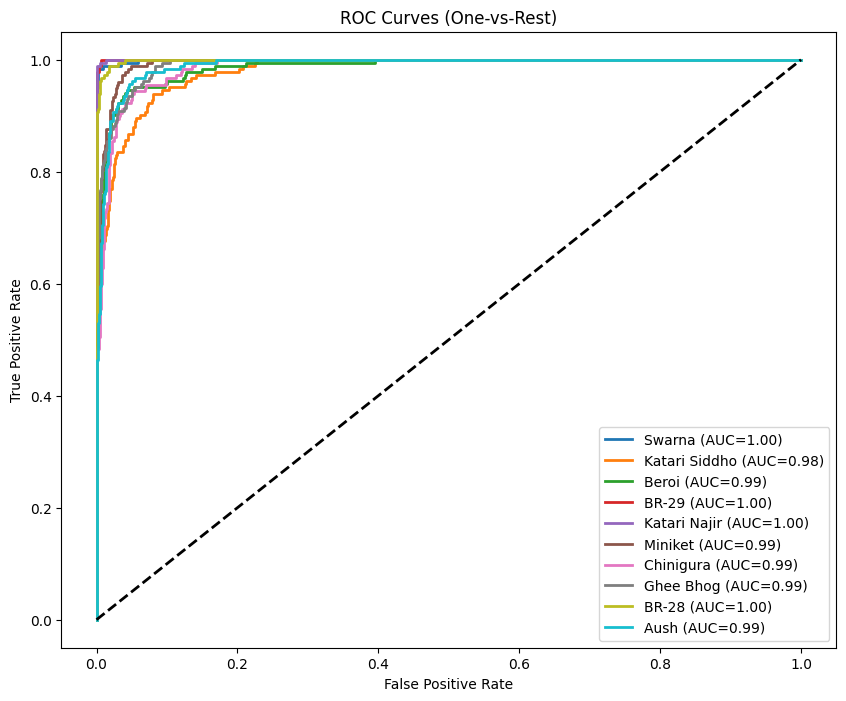

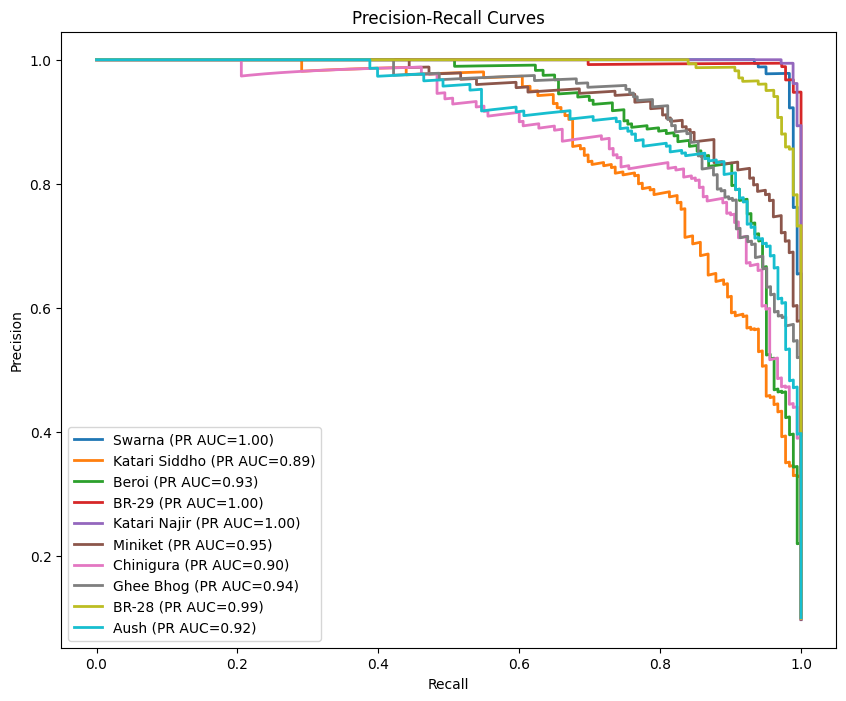


Stage 1 Training Time: 505.99 sec
Total Training Time (including fine-tuning): 760.26 sec

Most confused class pairs:
Swarna is most often confused with BR-29 (5 samples)
Katari Siddho is most often confused with Ghee Bhog (34 samples)
Beroi is most often confused with Aush (13 samples)
BR-29 is most often confused with Swarna (4 samples)
Katari Najir is most often confused with Miniket (3 samples)
Miniket is most often confused with Chinigura (2 samples)
Chinigura is most often confused with Miniket (60 samples)
Ghee Bhog is most often confused with Katari Siddho (12 samples)
BR-28 is most often confused with Katari Siddho (14 samples)
Aush is most often confused with Ghee Bhog (19 samples)


In [42]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/kaggle/input/microscopic-image-of-different-processed-rice/PRBD Microscopic Image of Different Processed Rice/Original_Images"
img_size = (299, 299)
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators with augmentation
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Build InceptionV3 model with fine-tuning option
# -----------------------------
def build_inception_model(input_shape=(299,299,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone initially
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model, base_model

model, base_model = build_inception_model(num_classes=num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Stage 1: Train top layers
# -----------------------------
start_time = time.time()
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
training_time_stage1 = time.time() - start_time

# -----------------------------
# Stage 2: Fine-tune last 50 layers of base_model
# -----------------------------
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 20
total_epochs = len(history.history['accuracy']) + fine_tune_epochs

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=total_epochs,
    initial_epoch=len(history.history['accuracy']),
    callbacks=[reduce_lr, early_stop],
    verbose=2
)
training_time_stage2 = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, model)

# -----------------------------
# Classification report & confusion matrix
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# -----------------------------
# Per-class metrics
# -----------------------------
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')
print(f"Macro Precision: {macro_precision:.4f}, Macro Recall: {macro_recall:.4f}, Macro F1-score: {macro_f1:.4f}")

# -----------------------------
# ROC-AUC & PR Curves
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC={pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Training time
# -----------------------------
print(f"\nStage 1 Training Time: {training_time_stage1:.2f} sec")
print(f"Total Training Time (including fine-tuning): {training_time_stage2:.2f} sec")

cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)

print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")


In [23]:
# -----------------------------
# Inference time per sample
# -----------------------------
start_test = time.time()
_ = model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference Time per sample: 0.017468 seconds


In [25]:

# Model parameter summary
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")


Total Parameters: 22,857,002
Trainable Parameters: 8,227,530
Non-Trainable Parameters: 14,629,472


Found 934 images belonging to 10 classes.
Found 119 images belonging to 10 classes.
Found 1812 images belonging to 10 classes.

--- Training for 50 epochs ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
30/30 - 43s - 1s/step - accuracy: 0.1424 - loss: 2.4833 - val_accuracy: 0.2437 - val_loss: 2.1536 - learning_rate: 0.0010
Epoch 2/50
30/30 - 17s - 565ms/step - accuracy: 0.1777 - loss: 2.2336 - val_accuracy: 0.3697 - val_loss: 1.9511 - learning_rate: 0.0010
Epoch 3/50
30/30 - 17s - 574ms/step - accuracy: 0.2066 - loss: 2.1560 - val_accuracy: 0.2773 - val_loss: 2.0154 - learning_rate: 0.0010
Epoch 4/50
30/30 - 17s - 570ms/step - accuracy: 0.2484 - loss: 2.0531 - val_accuracy: 0.3529 - val_loss: 1.8153 - learning_rate: 0.0010
Epoch 5/50
30/30 - 17s - 574ms/step - accuracy: 0.2281 - loss: 2.0096 - val_accuracy: 0.3193 - val_loss: 1.8388 - learning_rate: 0.0010
Epoch 6/50
30/30 - 17s - 569ms/step - accuracy: 0.2463 - loss: 1.9884 - val_accuracy: 0.3782 - val_loss: 1.7554 - learning_rate: 0.0010
Epoch 7/50
30/30 - 17s - 568ms/step - accuracy: 0.2741 - loss: 1.9136 - val_accuracy: 0.3529 - val_loss: 1.7895 - learning_rate: 0.0010
Epoch 8/50
30/30 - 17s - 565ms/step - accuracy: 0.2

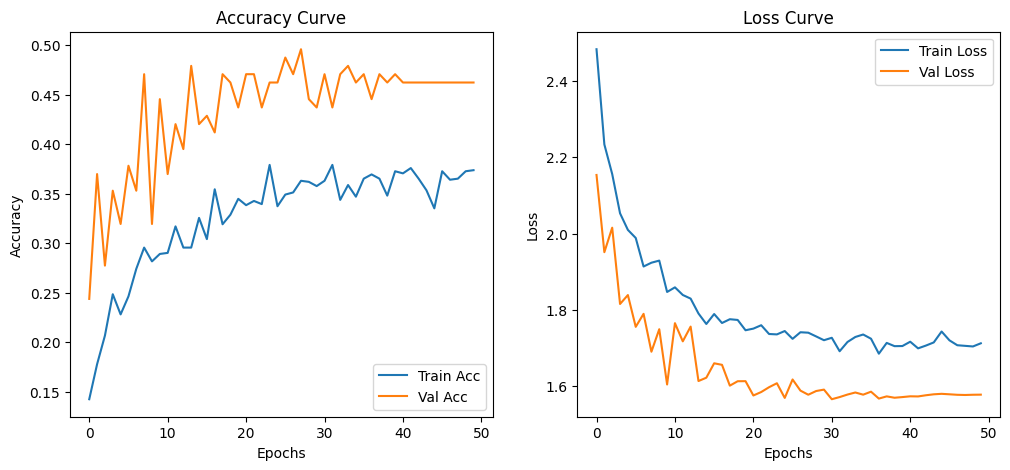


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.6800    0.7514    0.7139       181
Katari Siddho     0.1552    0.0495    0.0750       182
        Beroi     0.2143    0.0164    0.0305       183
        BR-29     0.8718    0.3736    0.5231       182
 Katari Najir     0.8544    0.4972    0.6286       177
      Miniket     0.3065    0.5337    0.3893       178
    Chinigura     0.4286    0.3500    0.3853       180
    Ghee Bhog     0.3333    0.3243    0.3288       185
        BR-28     0.4642    0.8950    0.6113       181
         Aush     0.3780    0.7705    0.5072       183

     accuracy                         0.4553      1812
    macro avg     0.4686    0.4562    0.4193      1812
 weighted avg     0.4674    0.4553    0.4182      1812



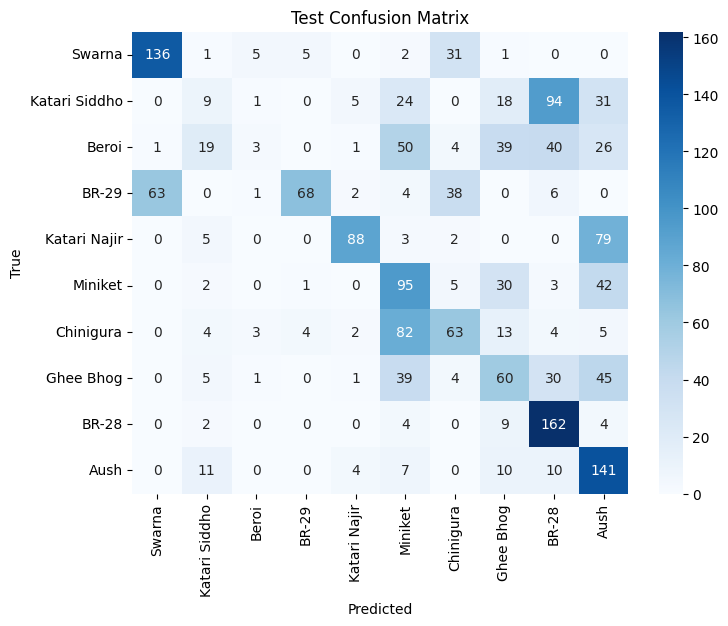

Swarna Accuracy: 0.7514
Katari Siddho Accuracy: 0.0495
Beroi Accuracy: 0.0164
BR-29 Accuracy: 0.3736
Katari Najir Accuracy: 0.4972
Miniket Accuracy: 0.5337
Chinigura Accuracy: 0.3500
Ghee Bhog Accuracy: 0.3243
BR-28 Accuracy: 0.8950
Aush Accuracy: 0.7705

Macro Precision: 0.4686
Macro Recall: 0.4562
Macro F1-score: 0.4193


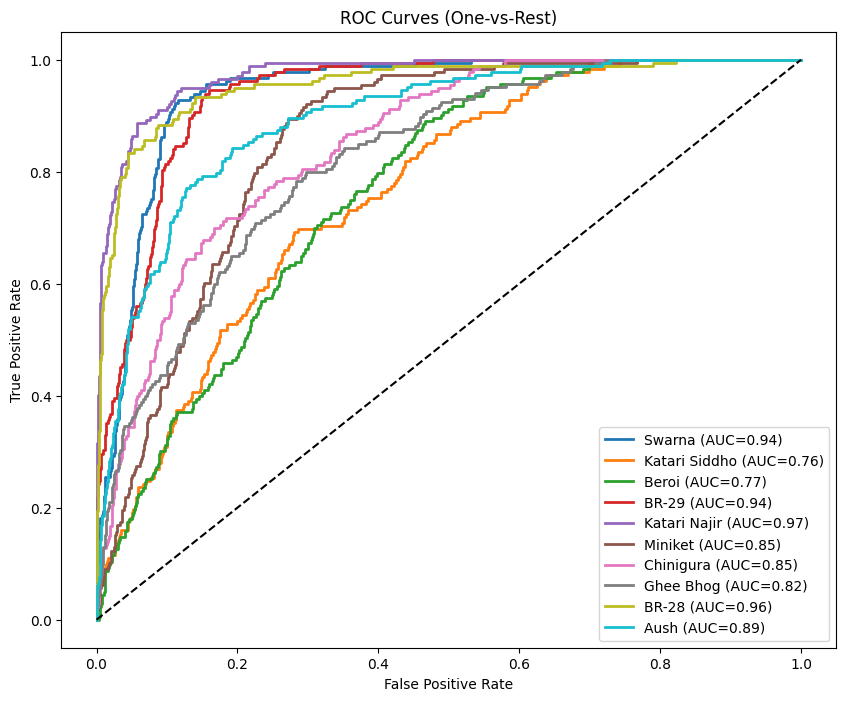

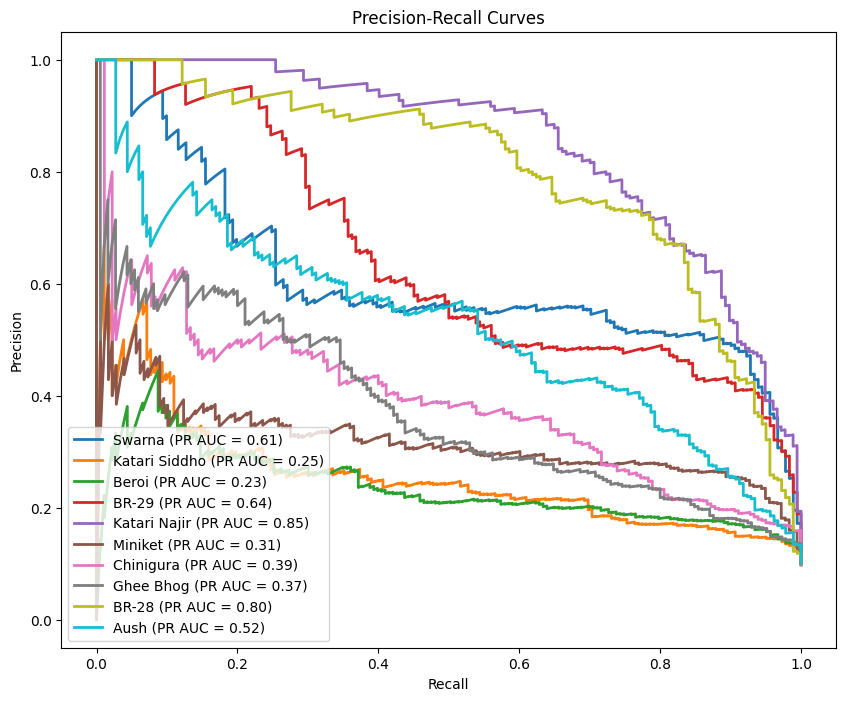


Most confused class pairs:
Swarna is most often confused with Chinigura (31 samples)
Katari Siddho is most often confused with BR-28 (94 samples)
Beroi is most often confused with Miniket (50 samples)
BR-29 is most often confused with Swarna (63 samples)
Katari Najir is most often confused with Aush (79 samples)
Miniket is most often confused with Aush (42 samples)
Chinigura is most often confused with Miniket (82 samples)
Ghee Bhog is most often confused with Aush (45 samples)
BR-28 is most often confused with Ghee Bhog (9 samples)
Aush is most often confused with Katari Siddho (11 samples)

Total Training Time: 886.66 sec


In [43]:
import os
import time
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/kaggle/input/microscopic-image-of-different-processed-rice/PRBD Microscopic Image of Different Processed Rice/Original_Images"
img_size = (224, 224)
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Build ResNet50 model
# -----------------------------
def build_resnet_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

resnet_model = build_resnet_model(num_classes=num_classes)

# -----------------------------
# Compile model
# -----------------------------
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# -----------------------------
# Callback
# -----------------------------
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Train for 50 epochs (no fine-tuning)
# -----------------------------
print("\n--- Training for 50 epochs ---")
start_time = time.time()
history = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[reduce_lr],
    verbose=2
)
training_time = time.time() - start_time

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, resnet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# -----------------------------
# Metrics
# -----------------------------
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

macro_precision = precision_score(test_true, test_pred, average='macro')
macro_recall = recall_score(test_true, test_pred, average='macro')
macro_f1 = f1_score(test_true, test_pred, average='macro')

print(f"\nMacro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# -----------------------------
# ROC–AUC curves
# -----------------------------
y_true_bin = label_binarize(test_true, classes=range(num_classes))
plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()


# -----------------------------
# PR curves
# -----------------------------

plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()


# Most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(confusion_matrix(test_true, test_pred), index=classes, columns=classes)
print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")

print(f"\nTotal Training Time: {training_time:.2f} sec")


In [45]:
# -----------------------------
# Inference time per sample
# -----------------------------
start_test = time.time()
_ = resnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Inference Time per sample: 0.011668 seconds


In [46]:
# -----------------------------
# Inference time per sample
# -----------------------------
start_test = time.time()
_ = resnet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
print(f"Inference time per sample: {inference_time/test_gen.samples:.6f} sec")
print(f"Total inference time for {test_gen.samples} samples: {inference_time:.2f} sec")

# -----------------------------
# Model parameters summary
# -----------------------------
total_params = resnet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in resnet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in resnet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")


Inference time per sample: 0.007481 sec
Total inference time for 1812 samples: 13.56 sec
Total Parameters: 24,641,930
Trainable Parameters: 1,054,218
Non-Trainable Parameters: 23,587,712


Found 934 images belonging to 10 classes.
Found 119 images belonging to 10 classes.
Found 1812 images belonging to 10 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
30/30 - 73s - 2s/step - accuracy: 0.4690 - loss: 1.6304 - val_accuracy: 0.7311 - val_loss: 0.8173 - learning_rate: 0.0010
Epoch 2/50
30/30 - 8s - 261ms/step - accuracy: 0.7409 - loss: 0.7460 - val_accuracy: 0.7899 - val_loss: 0.5916 - learning_rate: 0.0010
Epoch 3/50
30/30 - 8s - 270ms/step - accuracy: 0.8084 - loss: 0.6004 - val_accuracy: 0.8571 - val_loss: 0.4347 - learning_rate: 0.0010
Epoch 4/50
30/30 - 8s - 263ms/step - accuracy: 0.8437 - loss: 0.4737 - val_accuracy: 0.9076 - val_loss: 0.3727 - learning_rate: 0.0010
Epoch 5/50
30/30 - 8s - 263ms/step - accuracy: 0.8747 - loss: 0.4269 - val_accuracy: 0.8908 - val_loss: 0.3652 - learning_rate: 0.0010
Epoch 6/50
30/30 - 8s - 262ms/step - accuracy: 0.8565 - loss: 0.4430 - val_accuracy: 0.8235 - val_loss: 0.4836 - learning_rate: 0.0010
Epoch 7/50
30/

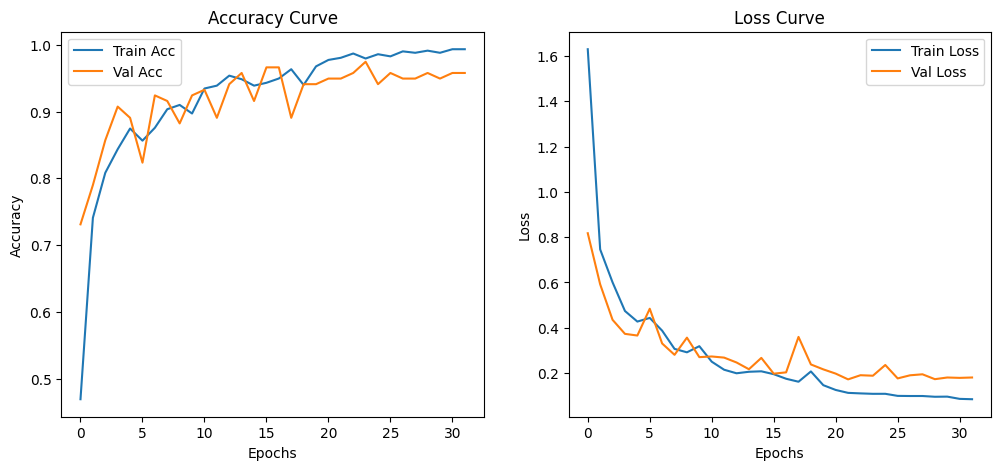


Test Classification Report:
               precision    recall  f1-score   support

       Swarna     0.9944    0.9834    0.9889       181
Katari Siddho     0.8743    0.9176    0.8954       182
        Beroi     0.9503    0.9399    0.9451       183
        BR-29     0.9891    0.9945    0.9918       182
 Katari Najir     0.9832    0.9944    0.9888       177
      Miniket     0.9394    0.8708    0.9038       178
    Chinigura     0.8973    0.9222    0.9096       180
    Ghee Bhog     0.9494    0.9135    0.9311       185
        BR-28     0.9831    0.9613    0.9721       181
         Aush     0.9175    0.9727    0.9443       183

     accuracy                         0.9470      1812
    macro avg     0.9478    0.9470    0.9471      1812
 weighted avg     0.9477    0.9470    0.9470      1812



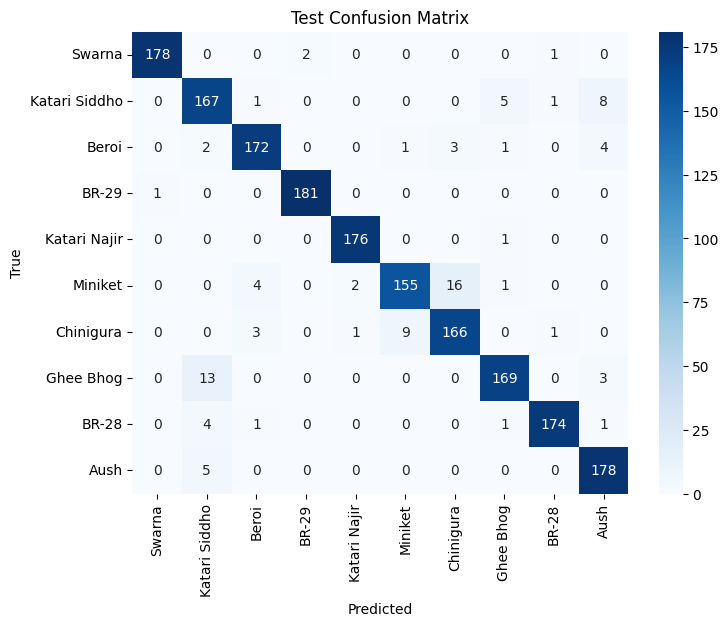

Swarna Accuracy: 0.9834
Katari Siddho Accuracy: 0.9176
Beroi Accuracy: 0.9399
BR-29 Accuracy: 0.9945
Katari Najir Accuracy: 0.9944
Miniket Accuracy: 0.8708
Chinigura Accuracy: 0.9222
Ghee Bhog Accuracy: 0.9135
BR-28 Accuracy: 0.9613
Aush Accuracy: 0.9727


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Total inference time: 33.45 sec
Inference time per sample: 0.018459 sec


In [48]:
import os
import time
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -----------------------------
# Paths and parameters
# -----------------------------
split_base_dir = '/kaggle/working/split_data'
dataset_dir = "/kaggle/input/microscopic-image-of-different-processed-rice/PRBD Microscopic Image of Different Processed Rice/Original_Images"
img_size = (224, 224)  # DenseNet121 default input
batch_size = 32
num_classes = 10
classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

# -----------------------------
# Data generators
# -----------------------------
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    os.path.join(split_base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# -----------------------------
# Model: DenseNet121
# -----------------------------
def build_densenet_model(input_shape=(224,224,3), num_classes=10, dropout_rate=0.3, l2_reg=1e-4):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # freeze backbone
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model

densenet_model = build_densenet_model(num_classes=num_classes)
densenet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# Callbacks
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # increased patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -----------------------------
# Training
# -----------------------------
start_time = time.time()
history = densenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,  # increased epochs
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
training_time = time.time() - start_time
print(f"Total training time: {training_time:.2f} sec")

# -----------------------------
# Plot training curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -----------------------------
# Evaluation function
# -----------------------------
def evaluate_model(generator, model):
    steps = int(np.ceil(generator.samples / generator.batch_size))
    y_true = []
    y_pred_prob = []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        preds = model.predict(x_batch, verbose=0)
        y_true.append(y_batch)
        y_pred_prob.append(preds)
    y_true = np.vstack(y_true)
    y_pred_prob = np.vstack(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)
    return y_true_labels, y_pred, y_true, y_pred_prob

train_true, train_pred, train_true_prob, train_pred_prob = evaluate_model(train_gen, densenet_model)
val_true, val_pred, val_true_prob, val_pred_prob = evaluate_model(val_gen, densenet_model)
test_true, test_pred, test_true_prob, test_pred_prob = evaluate_model(test_gen, densenet_model)

# -----------------------------
# Reports
# -----------------------------
print("\nTest Classification Report:")
print(classification_report(test_true, test_pred, digits=4, target_names=classes))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for cls, acc in zip(classes, per_class_acc):
    print(f"{cls} Accuracy: {acc:.4f}")

# -----------------------------
# Testing / Inference time per sample
# -----------------------------
start_infer = time.time()
_ = densenet_model.predict(test_gen, verbose=0)
total_infer_time = time.time() - start_infer
time_per_sample = total_infer_time / test_gen.samples
print(f"Total inference time: {total_infer_time:.2f} sec")
print(f"Inference time per sample: {time_per_sample:.6f} sec")


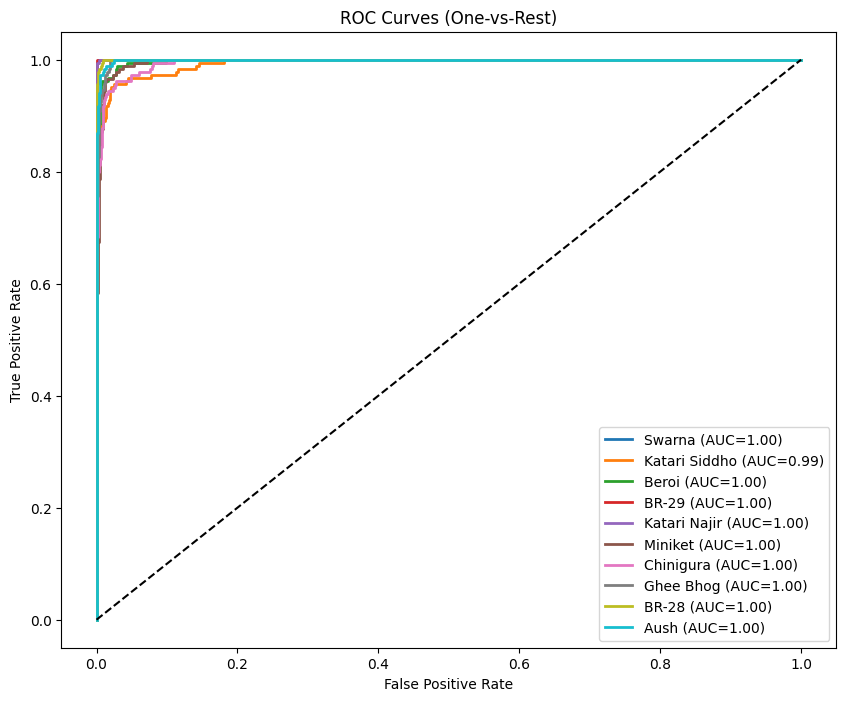

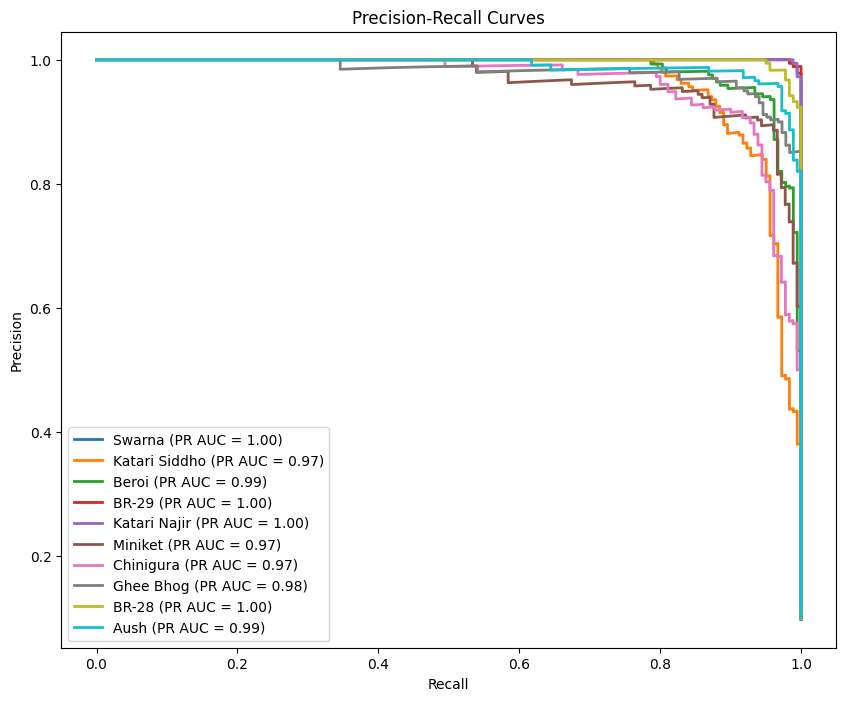


Most confused class pairs:
Swarna is most often confused with BR-29 (2 samples)
Katari Siddho is most often confused with Aush (8 samples)
Beroi is most often confused with Aush (4 samples)
BR-29 is most often confused with Swarna (1 samples)
Katari Najir is most often confused with Ghee Bhog (1 samples)
Miniket is most often confused with Chinigura (16 samples)
Chinigura is most often confused with Miniket (9 samples)
Ghee Bhog is most often confused with Katari Siddho (13 samples)
BR-28 is most often confused with Katari Siddho (4 samples)
Aush is most often confused with Katari Siddho (5 samples)

Total Training Time: 315.34 sec


In [49]:
 #ROC–AUC curves

y_true_bin = label_binarize(test_true, classes=range(num_classes))
plt.figure(figsize=(10,8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{classes[i]} (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# -----------------------------
# Precision–Recall curves
# -----------------------------
plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision_vals, recall_vals, _ = precision_recall_curve(y_true_bin[:, i], test_pred_prob[:, i])
    pr_auc = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, lw=2, label=f'{classes[i]} (PR AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# -----------------------------
# Most confused class pairs
# -----------------------------
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
print("\nMost confused class pairs:")
for cls in classes:
    row = cm_df.loc[cls].copy()
    row[cls] = 0
    most_confused = row.idxmax()
    print(f"{cls} is most often confused with {most_confused} ({row.max()} samples)")

print(f"\nTotal Training Time: {training_time:.2f} sec")

In [50]:
# -----------------------------
# Inference time per sample
# -----------------------------
start_test = time.time()
_ = densenet_model.predict(test_gen, verbose=0)
inference_time = time.time() - start_test
samples = test_gen.samples
print(f"Inference Time per sample: {inference_time/samples:.6f} seconds")


Inference Time per sample: 0.007484 seconds


In [51]:
# -----------------------------
# Calculate and print model parameters
# -----------------------------
total_params = densenet_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in densenet_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in densenet_model.non_trainable_weights])

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Non-Trainable Parameters: {non_trainable_params:,}")


Total Parameters: 7,567,434
Trainable Parameters: 529,930
Non-Trainable Parameters: 7,037,504
